### ASTR 598 - Astrostatistics - Class Project - Group 1

- Tyler Gordon
- Meredith Durbin 
- Brianna Thomas
- Joachim Moeyens
- Dino Bektesevic

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from crossmatch import xmatch

from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord

% matplotlib inline

### Data Acquisition

[Google Drive for NSC files and xmatch arrays](https://drive.google.com/drive/folders/1r0LgsJ4LjUgcxUIYwPUZl-YcwxqO0z5c?usp=sharing)

[Website for HLC files](http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/)

In [2]:
# Assumes there is a directory called data 
# in the same level as this notebook
DATA_DIR = "data/"
HLC_FILES = sorted(glob.glob(os.path.join(DATA_DIR, "HLC*.fits")))
NSC_FILES = sorted(glob.glob(os.path.join(DATA_DIR, "stripe82*.txt")))
# Sorting insures cross OS compatibility for list ordering

In [3]:
sorted(os.listdir(DATA_DIR))

['HLC.RA_00_to_01.fits',
 'HLC.RA_01_to_02.fits',
 'HLC.RA_02_to_03.fits',
 'HLC.RA_03_to_04.fits',
 'HLC.RA_20_to_21.fits',
 'HLC.RA_21_to_22.fits',
 'HLC.RA_22_to_23.fits',
 'HLC.RA_23_to_24.fits',
 'manxmatch_hlc_nsc_d2d.txt',
 'manxmatch_hlc_nsc_idx.txt',
 'manxmatch_nsc_hlc_d2d.txt',
 'manxmatch_nsc_hlc_idx.txt',
 'stripe82_315_ra_45_-1_3_dec_0.txt',
 'stripe82_315_ra_45_0_dec_1_3.txt',
 'xmatch_hlc_nsc_1arcsec_dist.txt',
 'xmatch_hlc_nsc_1arcsec_idx.txt',
 'xmatch_nsc_hlc_1arcsec_dist.txt',
 'xmatch_nsc_hlc_1arcsec_idx.txt']

In [4]:
HLC_FILES

['data/HLC.RA_00_to_01.fits',
 'data/HLC.RA_01_to_02.fits',
 'data/HLC.RA_02_to_03.fits',
 'data/HLC.RA_03_to_04.fits',
 'data/HLC.RA_20_to_21.fits',
 'data/HLC.RA_21_to_22.fits',
 'data/HLC.RA_22_to_23.fits',
 'data/HLC.RA_23_to_24.fits']

In [5]:
NSC_FILES

['data/stripe82_315_ra_45_-1_3_dec_0.txt',
 'data/stripe82_315_ra_45_0_dec_1_3.txt']

In [6]:
# Simple function to read in HLC and NSC files into a single dataframe

def buildHLCDataFrame(datafiles,
                      filters=["u", "g", "r", "i", "z"],
                      columns=["RA_MEAN", "DEC_MEAN",
                               "MEAN_PSFMAG", "MEAN_PSFMAG_ERR",
                               "MEAN_OBJECT_TYPE", "RA_PM_CLIP", 
                               "RA_PM_ERR_CLIP", "DEC_PM_CLIP",
                               "DEC_PM_ERR_CLIP"],
                      makeColors=True,
                      magColumnName="MEAN_PSFMAG",
                      colors=["g-i"]):
    
    dfs = []
    for datafile in datafiles:
        hdul = fits.open(datafile)
        data = hdul[1].data
        df = pd.DataFrame()

        for column in columns:
            # Assume multi-dimensional fits columns are keyed on filters
            if data[column][0].shape == (len(filters),):
                for i, filt in enumerate(filters):
                    df["{}_{}".format(column, filt)] = data[column][:, i]
            # If not multi-dimensional just add to dataframe as normal
            elif data[column][0].shape == ():
                df[column] = data[column]
            # If it isn't singular in dimension, or fits the expected number of filters
            # raise a hopefully useful error
            else:
                raise ValueError("Shape of multi-dimensional column data does not match number of filters!")

        if makeColors is True:
            for color in colors:
                # color = filt2 - filt1
                filt1 = color.split("-")[1]
                filt2 = color.split("-")[0]
                df[color] = df["{}_{}".format(magColumnName, filt2)] - df["{}_{}".format(magColumnName, filt1)]
        dfs.append(df)
    final = pd.concat(dfs)
    final.reset_index(inplace=True, drop=True)
    return final

def buildNSCDataFrame(datafiles):

    dfs = []
    for datafile in datafiles:
        df = pd.read_csv(NSC_FILES[0], sep=" ")
        dfs.append(df)
    
    final = pd.concat(dfs)
    final.reset_index(inplace=True, drop=True)
    return final

In [7]:
hlc = buildHLCDataFrame(HLC_FILES)

In [8]:
hlc.head()

,RA_MEAN,DEC_MEAN,MEAN_PSFMAG_u,MEAN_PSFMAG_g,MEAN_PSFMAG_r,MEAN_PSFMAG_i,MEAN_PSFMAG_z,MEAN_PSFMAG_ERR_u,MEAN_PSFMAG_ERR_g,MEAN_PSFMAG_ERR_r,MEAN_PSFMAG_ERR_i,MEAN_PSFMAG_ERR_z,MEAN_OBJECT_TYPE,RA_PM_CLIP,RA_PM_ERR_CLIP,DEC_PM_CLIP,DEC_PM_ERR_CLIP,g-i
0,0.000012,-0.681220,0.0000,22.679943,21.688560,21.280607,20.960501,0.000000,0.070077,0.044086,0.038800,0.177185,3.2,0.014193,0.010227,0.037836,0.010227,1.399336
1,0.000035,0.475404,0.0000,22.494812,21.485416,21.199217,20.647459,0.000000,0.041831,0.025648,0.031936,0.111785,3.0,-0.016163,0.008770,0.030977,0.008770,1.295595
2,0.000151,1.059526,0.0000,21.816391,22.191387,20.808842,20.021967,0.000000,0.097663,0.028077,0.012231,0.020769,5.4,-0.012494,0.003727,-0.006675,0.003727,1.007549
3,0.000205,-0.838721,19.7705,18.835068,18.476278,18.329546,18.270407,0.041607,0.003259,0.002162,0.002186,0.003870,6.0,0.015038,0.002609,-0.001602,0.002609,0.505522
4,0.000228,0.077162,0.0000,20.968287,19.645609,18.767252,18.273226,0.000000,0.008626,0.004235,0.003535,0.006249,6.0,-0.012199,0.003451,-0.009051,0.003451,2.201035


In [9]:
nsc = buildNSCDataFrame(NSC_FILES)

In [10]:
nsc.head()

,ra,dec,pmra,pmraerr,pmdec,pmdecerr,mjd,deltamjd,gmag,grms,...,rmag,rrms,rerr,imag,irms,ierr,class_star,fwhm,ebv,nphot
0,315.012148,-1.298594,1275.324779,1314.590162,-91.929458,1398.319357,57598.697285,10.879461,99.989998,999999.0,...,20.612076,999999.0,0.027147,99.989998,999999.0,9.99,0.978889,1.380337,0.087262,2
1,315.010754,-1.297880,-714.960501,3414.340885,-272.622409,3447.444185,57598.697285,10.879461,99.989998,999999.0,...,21.986279,999999.0,0.079821,99.989998,999999.0,9.99,0.899216,1.522221,0.087286,2
2,315.013867,-1.296287,-2339.889414,6293.682515,-2186.863370,6311.702668,57598.697285,10.879461,99.989998,999999.0,...,22.269653,999999.0,0.095987,99.989998,999999.0,9.99,0.340959,2.487719,0.087237,2
3,315.003075,-1.293646,106.992177,118.045727,18.378282,119.195841,57717.185732,360.905060,22.649281,999999.0,...,21.409351,999999.0,0.052671,99.989998,999999.0,9.99,0.866193,1.791050,0.087430,3
4,315.003150,-1.291179,-1.564847,24.141297,-6.216486,29.390321,57717.185732,360.905060,18.699413,999999.0,...,18.291037,999999.0,0.006475,99.989998,999999.0,9.99,0.984123,1.374196,0.087436,3


### Crossmatching (using DataLab crossmatch.py)

In [11]:
### 1 arcsecond in degrees
arcsecond = 0.000277778
DO_CROSSMATCH = False

In [12]:
if DO_CROSSMATCH:
    matched_1arcsec = xmatch(hlc["RA_MEAN"].values,
                             hlc["DEC_MEAN"].values,
                             nsc["ra"].values,
                             nsc["dec"].values,
                             maxdist=arcsecond)
    reverse_matched_1arcsec = xmatch(nsc["ra"].values,
                                     nsc["dec"].values,
                                     hlc["RA_MEAN"].values,
                                     hlc["DEC_MEAN"].values,
                                     maxdist=arcsecond)
    
    np.savetxt("xmatch_hlc_nsc_1arcsec_idx.txt",  matched_1arcsec[0], fmt="%i")
    np.savetxt("xmatch_hlc_nsc_1arcsec_dist.txt", matched_1arcsec[1])
    
    np.savetxt("xmatch_nsc_hlc_1arcsec_idx.txt",  reverse_matched_1arcsec[0], fmt="%i")
    np.savetxt("xmatch_nsc_hlc_1arcsec_dist.txt", reverse_matched_1arcsec[1])
else:
    nsc2hlc_mask_1arcsec = np.loadtxt(os.path.join(DATA_DIR,"xmatch_hlc_nsc_1arcsec_idx.txt"), unpack=True)
    nsc2hlc_mask_dist_1arcsec = np.loadtxt(os.path.join(DATA_DIR,"xmatch_hlc_nsc_1arcsec_dist.txt"), unpack=True)
    
    hlc2nsc_mask_1arcsec = np.loadtxt(os.path.join(DATA_DIR,"xmatch_nsc_hlc_1arcsec_idx.txt"), unpack=True)
    hlc2nsc_mask_dist_1arcsec = np.loadtxt(os.path.join(DATA_DIR,"xmatch_nsc_hlc_1arcsec_dist.txt"), unpack=True)
    
    print("1 arcsecond max distance crossmatch found {} matched sources".format(len(nsc2hlc_mask_1arcsec)))
    print("1 arcsecond max distance reverse crossmatch found {} matched sources".format(len(hlc2nsc_mask_1arcsec)))

1 arcsecond max distance crossmatch found 1481111 matched sources
1 arcsecond max distance reverse crossmatch found 3218120 matched sources


In [ ]:
if DO_CROSSMATCH:
    matched_2arcsec = xmatch(hlc["RA_MEAN"].values,
                             hlc["DEC_MEAN"].values,
                             nsc["ra"].values,
                             nsc["dec"].values,
                             maxdist=2*arcsecond)
    reverse_matched_2arcsec = xmatch(nsc["ra"].values,
                                     nsc["dec"].values,
                                     hlc["RA_MEAN"].values,
                                     hlc["DEC_MEAN"].values,
                                     maxdist=2*arcsecond)
    
    np.savetxt("xmatch_hlc_nsc_1arcsec_idx.txt",  matched_2arcsec[0], fmt="%i")
    np.savetxt("xmatch_hlc_nsc_1arcsec_dist.txt", matched_2arcsec[1])
    
    np.savetxt("xmatch_nsc_hlc_1arcsec_idx.txt",  reverse_matched_2arcsec[0], fmt="%i")
    np.savetxt("xmatch_nsc_hlc_1arcsec_dist.txt", reverse_matched_2arcsec[1])
else:
    nsc2hlc_mask_1arcsec = np.loadtxt(os.path.join(DATA_DIR,"xmatch_hlc_nsc_2arcsec_idx.txt"), unpack=True)
    nsc2hlc_mask_dist_1arcsec = np.loadtxt(os.path.join(DATA_DIR,"xmatch_hlc_nsc_2arcsec_dist.txt"), unpack=True)
    
    hlc2nsc_mask_1arcsec = np.loadtxt(os.path.join(DATA_DIR,"xmatch_nsc_hlc_2arcsec_idx.txt"), unpack=True)
    hlc2nsc_mask_dist_1arcsec = np.loadtxt(os.path.join(DATA_DIR,"xmatch_nsc_hlc_2arcsec_dist.txt"), unpack=True)
    
    print("1 arcsecond max distance crossmatch found {} matched sources".format(len(nsc2hlc_mask_2arcsec)))
    print("1 arcsecond max distance reverse crossmatch found {} matched sources".format(len(hlc2nsc_mask_2arcsec)))

### Crossmatching (using AstroPy match to catalog)

In [13]:
man_nsc2hlc_mask = np.loadtxt(os.path.join(DATA_DIR,"manxmatch_hlc_nsc_idx.txt"), unpack=True)
man_nsc2hlc_mask_dist = np.loadtxt(os.path.join(DATA_DIR,"manxmatch_nsc_hlc_d2d.txt"), unpack=True)
    
man_hlc2nsc_mask = np.loadtxt(os.path.join(DATA_DIR,"manxmatch_hlc_nsc_idx.txt"), unpack=True)
man_hlc2nsc_mask_dist = np.loadtxt(os.path.join(DATA_DIR,"manxmatch_hlc_nsc_d2d.txt"), unpack=True)
    
print("1 arcsecond max distance crossmatch found {} matched sources".format(len(man_nsc2hlc_mask)))
print("1 arcsecond max distance reverse crossmatch found {} matched sources".format(len(man_hlc2nsc_mask)))

1 arcsecond max distance crossmatch found 3700548 matched sources
1 arcsecond max distance reverse crossmatch found 3700548 matched sources


In [14]:
hlcmask = man_hlc2nsc_mask_dist < arcsecond
maskedhlc = hlc.iloc[hlcmask]
maskednsc = nsc.iloc[man_hlc2nsc_mask[hlcmask]]
print len(hlcmask)
print len(maskedhlc), len(maskednsc)

3700548
1481111 1481111


In [15]:
maskedhlc

,RA_MEAN,DEC_MEAN,MEAN_PSFMAG_u,MEAN_PSFMAG_g,MEAN_PSFMAG_r,MEAN_PSFMAG_i,MEAN_PSFMAG_z,MEAN_PSFMAG_ERR_u,MEAN_PSFMAG_ERR_g,MEAN_PSFMAG_ERR_r,MEAN_PSFMAG_ERR_i,MEAN_PSFMAG_ERR_z,MEAN_OBJECT_TYPE,RA_PM_CLIP,RA_PM_ERR_CLIP,DEC_PM_CLIP,DEC_PM_ERR_CLIP,g-i
3,0.000205,-0.838721,19.770500,18.835068,18.476278,18.329546,18.270407,0.041607,0.003259,0.002162,0.002186,0.003870,6.000000,0.015038,0.002609,-0.001602,0.002609,0.505522
5,0.000231,-0.884495,0.000000,21.792530,20.555449,20.025230,19.577593,0.000000,0.016002,0.006463,0.006475,0.013090,3.000000,0.003141,0.003565,-0.001235,0.003565,1.767300
6,0.000273,-1.034293,19.893600,17.600039,16.642000,16.305443,16.108389,0.044951,0.003535,0.002460,0.003001,0.002858,6.000000,0.015749,0.002790,-0.007957,0.002790,1.294596
8,0.000318,-1.109972,0.000000,22.485987,21.207006,20.660536,20.128004,0.000000,0.032363,0.011946,0.011219,0.023357,3.192661,-0.008090,0.004226,0.001856,0.004226,1.825451
9,0.000336,-0.232274,0.000000,22.068806,20.498985,19.896221,19.546129,0.000000,0.017386,0.006849,0.006642,0.014555,3.000000,0.003147,0.003733,0.001838,0.003733,2.172585
12,0.000433,-0.273026,0.000000,20.672821,19.571205,19.012926,18.743595,0.000000,0.026159,0.022034,0.013283,0.025962,6.000000,-0.033472,0.013541,-0.006715,0.013541,1.659895
15,0.000583,-1.051291,0.000000,21.798851,21.326443,21.097767,20.677563,0.000000,0.012327,0.009180,0.011031,0.043014,3.014852,-0.004630,0.004670,0.000739,0.004670,0.701084
16,0.000617,-0.478180,0.000000,22.258339,21.569609,21.281862,20.626692,0.000000,0.022832,0.016383,0.017493,0.076234,3.074074,-0.010079,0.007463,-0.007125,0.007463,0.976477
20,0.000674,-0.185724,0.000000,19.869778,19.299391,18.885073,18.612310,0.000000,0.004490,0.003606,0.003668,0.007010,3.000000,0.001555,0.003416,0.003671,0.003416,0.984705
27,0.000805,-0.349574,0.000000,22.454451,21.026520,19.686407,18.976625,0.000000,0.024609,0.009885,0.005553,0.009203,5.895652,-0.006876,0.003656,-0.014920,0.003656,2.768044


In [16]:
maskednsc

,ra,dec,pmra,pmraerr,pmdec,pmdecerr,mjd,deltamjd,gmag,grms,...,rmag,rrms,rerr,imag,irms,ierr,class_star,fwhm,ebv,nphot
5691543,0.000244,-0.838740,10.876373,3.030742,1.210599,2.831490,56498.023357,1460.87290,18.762619,0.059578,...,18.520668,0.035301,0.002395,18.410328,0.073018,0.002746,0.930065,1.362378,0.044583,80
1974876,0.000236,-0.884514,2.507448,5.775705,8.222375,5.519244,56713.863179,1434.02330,21.383150,0.051843,...,20.200712,0.082642,0.008526,19.700106,0.058764,0.009301,0.515197,1.872763,0.044947,32
5671620,0.000296,-1.034323,0.301460,7.739439,-7.893386,7.959357,56730.093871,756.02539,17.501537,0.010709,...,16.655796,0.010530,0.002147,16.347620,0.006777,0.001387,0.987241,1.182512,0.040455,18
1954877,0.000327,-1.109982,-1.497789,22.668595,25.113850,23.173913,56713.506893,756.02539,22.078550,0.097499,...,20.853060,0.033855,0.014778,20.331676,0.053169,0.017955,0.318032,1.946733,0.036733,20
1996436,0.000355,-0.232267,-11.881954,4.392845,-10.491498,4.193097,56436.013515,1460.87290,21.342197,0.285975,...,19.824633,0.146757,0.006848,19.314064,0.127583,0.008849,0.371105,2.337307,0.034175,183
1996351,0.000431,-0.273059,-11.423966,2.590009,-9.785423,2.688621,56453.833237,1473.83750,20.622543,0.117818,...,19.519642,0.089354,0.003520,19.067308,0.089157,0.004546,0.874406,1.473077,0.033955,213
5671582,0.000611,-1.051252,-33.228061,135.190488,-78.883896,135.325409,56594.275373,739.05902,20.973089,0.118495,...,20.549606,0.009611,0.022317,20.282557,0.011446,0.026900,0.073625,3.426476,0.039613,8
1981274,0.000622,-0.478192,7.402693,7.868930,-6.149692,7.836400,56601.572683,1473.83750,21.869776,0.145935,...,21.088326,0.127078,0.013481,20.937061,0.347208,0.021053,0.360274,1.973314,0.042401,76
5717650,0.000672,-0.185732,-5.417618,2.630192,7.158243,2.563743,56602.319971,1473.83750,18.522486,0.153878,...,17.920422,0.128251,0.001824,17.571087,0.102007,0.002554,0.068110,3.733211,0.034440,134
1995232,0.000802,-0.349599,-10.142363,2.880640,-8.332816,2.778505,56692.437730,1473.83750,22.301582,0.175121,...,20.946613,0.122681,0.009438,19.612158,0.130435,0.006262,0.802651,1.496587,0.035513,116


### Data Cleaning and Proper Motion Selection

### Chi-Squared Calculation

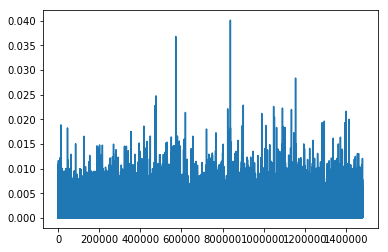

In [17]:
hlcrapm = maskedhlc["RA_PM_CLIP"].values
hlcrapmerr = maskedhlc["RA_PM_ERR_CLIP"].values
nscrapm = maskednsc["pmra"].values
nscrapmerr = maskednsc["pmraerr"].values
diffra = hlcrapm-(nscrapm/1000.)
sigmai = np.sqrt(  hlcrapmerr**2 + (nscrapmerr/1000.)**2 )
norm = 1/float(len(hlcrapm)-1)
chi2i = np.sqrt(norm*( diffra/sigmai )**2)
plt.plot(chi2i)
plt.show()

### Plotting

- Chi-squared distribution as a function of Ra and Dec
- Proper motion as a function of RA and Dec
- Others...

In [18]:
import astroML as aml
from astroML.plotting import setup_text_plots
from astroML.stats import binned_statistic_2d

setup_text_plots(fontsize=16, usetex=True)

num_bins=100

N, xedge, yedge = binned_statistic_2d(maskednsc["ra"], maskednsc["dec"], maskednsc["dec"], 'count', bins=num_bins)

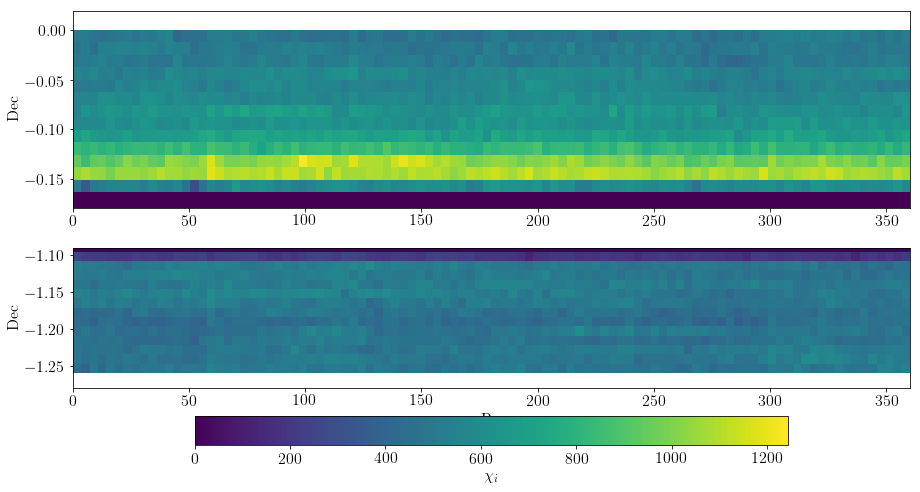

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
ax[0].imshow(N, origin='lower', aspect="auto", extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]])
ax[0].set_ylim(-0.18, 0.02)

i = ax[1].imshow(N, origin='lower', aspect="auto", extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]])
ax[1].set_ylim(-1.28, -1.09)

ax[0].set_ylabel("Dec")
ax[1].set_ylabel("Dec")
ax[1].set_xlabel("Ra")
plt.colorbar(mappable=i, ax=ax[1], pad=0.14, orientation='horizontal', label=r"$\chi_i$")
plt.show()

In [20]:
mnscra = maskednsc["ra"].values
mnscdec = maskednsc["dec"].values

print "Number of objects with -1<dec<-0.15: {0}".format(len(mnscdec[ (mnscdec<-0.15) & (mnscdec>-1) ]))

Number of objects with -1<dec<-0.15: 1003013


### Attempt at finding matching indices from a constrained crossmatch 

Remakably useless right now. Interesting lack of ~6000 objects is apparent after a `match_to_catalog_sky` with constrained `maxdist` that does not appear when manually fitlering for the constrain.

In [21]:
d = np.unique(hlc2nsc_mask_1arcsec)
e = np.unique(nsc2hlc_mask_1arcsec)
print "Number of unique matches for HLC and NSC respectively: {0}, {1}".format(len(hlc.iloc[d]), len(nsc.iloc[nsc2hlc_mask_1arcsec]))
print "Discrepancy between xmatch and reverse xmatch: {0}".format(len(hlc.iloc[d]) - len(nsc.iloc[nsc2hlc_mask_1arcsec]))

Number of unique matches for HLC and NSC respectively: 1475364, 1481111
Discrepancy between xmatch and reverse xmatch: -5747


In [22]:
hlc.iloc[d]

,RA_MEAN,DEC_MEAN,MEAN_PSFMAG_u,MEAN_PSFMAG_g,MEAN_PSFMAG_r,MEAN_PSFMAG_i,MEAN_PSFMAG_z,MEAN_PSFMAG_ERR_u,MEAN_PSFMAG_ERR_g,MEAN_PSFMAG_ERR_r,MEAN_PSFMAG_ERR_i,MEAN_PSFMAG_ERR_z,MEAN_OBJECT_TYPE,RA_PM_CLIP,RA_PM_ERR_CLIP,DEC_PM_CLIP,DEC_PM_ERR_CLIP,g-i
3,0.000205,-0.838721,19.770500,18.835068,18.476278,18.329546,18.270407,0.041607,0.003259,0.002162,0.002186,0.003870,6.000000,0.015038,0.002609,-0.001602,0.002609,0.505522
5,0.000231,-0.884495,0.000000,21.792530,20.555449,20.025230,19.577593,0.000000,0.016002,0.006463,0.006475,0.013090,3.000000,0.003141,0.003565,-0.001235,0.003565,1.767300
6,0.000273,-1.034293,19.893600,17.600039,16.642000,16.305443,16.108389,0.044951,0.003535,0.002460,0.003001,0.002858,6.000000,0.015749,0.002790,-0.007957,0.002790,1.294596
8,0.000318,-1.109972,0.000000,22.485987,21.207006,20.660536,20.128004,0.000000,0.032363,0.011946,0.011219,0.023357,3.192661,-0.008090,0.004226,0.001856,0.004226,1.825451
9,0.000336,-0.232274,0.000000,22.068806,20.498985,19.896221,19.546129,0.000000,0.017386,0.006849,0.006642,0.014555,3.000000,0.003147,0.003733,0.001838,0.003733,2.172585
12,0.000433,-0.273026,0.000000,20.672821,19.571205,19.012926,18.743595,0.000000,0.026159,0.022034,0.013283,0.025962,6.000000,-0.033472,0.013541,-0.006715,0.013541,1.659895
15,0.000583,-1.051291,0.000000,21.798851,21.326443,21.097767,20.677563,0.000000,0.012327,0.009180,0.011031,0.043014,3.014852,-0.004630,0.004670,0.000739,0.004670,0.701084
16,0.000617,-0.478180,0.000000,22.258339,21.569609,21.281862,20.626692,0.000000,0.022832,0.016383,0.017493,0.076234,3.074074,-0.010079,0.007463,-0.007125,0.007463,0.976477
20,0.000674,-0.185724,0.000000,19.869778,19.299391,18.885073,18.612310,0.000000,0.004490,0.003606,0.003668,0.007010,3.000000,0.001555,0.003416,0.003671,0.003416,0.984705
27,0.000805,-0.349574,0.000000,22.454451,21.026520,19.686407,18.976625,0.000000,0.024609,0.009885,0.005553,0.009203,5.895652,-0.006876,0.003656,-0.014920,0.003656,2.768044


In [23]:
nsc.iloc[nsc2hlc_mask_1arcsec]

,ra,dec,pmra,pmraerr,pmdec,pmdecerr,mjd,deltamjd,gmag,grms,...,rmag,rrms,rerr,imag,irms,ierr,class_star,fwhm,ebv,nphot
5691543,0.000244,-0.838740,10.876373,3.030742,1.210599,2.831490,56498.023357,1460.87290,18.762619,0.059578,...,18.520668,0.035301,0.002395,18.410328,0.073018,0.002746,0.930065,1.362378,0.044583,80
1974876,0.000236,-0.884514,2.507448,5.775705,8.222375,5.519244,56713.863179,1434.02330,21.383150,0.051843,...,20.200712,0.082642,0.008526,19.700106,0.058764,0.009301,0.515197,1.872763,0.044947,32
5671620,0.000296,-1.034323,0.301460,7.739439,-7.893386,7.959357,56730.093871,756.02539,17.501537,0.010709,...,16.655796,0.010530,0.002147,16.347620,0.006777,0.001387,0.987241,1.182512,0.040455,18
1954877,0.000327,-1.109982,-1.497789,22.668595,25.113850,23.173913,56713.506893,756.02539,22.078550,0.097499,...,20.853060,0.033855,0.014778,20.331676,0.053169,0.017955,0.318032,1.946733,0.036733,20
1996436,0.000355,-0.232267,-11.881954,4.392845,-10.491498,4.193097,56436.013515,1460.87290,21.342197,0.285975,...,19.824633,0.146757,0.006848,19.314064,0.127583,0.008849,0.371105,2.337307,0.034175,183
1996351,0.000431,-0.273059,-11.423966,2.590009,-9.785423,2.688621,56453.833237,1473.83750,20.622543,0.117818,...,19.519642,0.089354,0.003520,19.067308,0.089157,0.004546,0.874406,1.473077,0.033955,213
5671582,0.000611,-1.051252,-33.228061,135.190488,-78.883896,135.325409,56594.275373,739.05902,20.973089,0.118495,...,20.549606,0.009611,0.022317,20.282557,0.011446,0.026900,0.073625,3.426476,0.039613,8
1981274,0.000622,-0.478192,7.402693,7.868930,-6.149692,7.836400,56601.572683,1473.83750,21.869776,0.145935,...,21.088326,0.127078,0.013481,20.937061,0.347208,0.021053,0.360274,1.973314,0.042401,76
5717650,0.000672,-0.185732,-5.417618,2.630192,7.158243,2.563743,56602.319971,1473.83750,18.522486,0.153878,...,17.920422,0.128251,0.001824,17.571087,0.102007,0.002554,0.068110,3.733211,0.034440,134
1995232,0.000802,-0.349599,-10.142363,2.880640,-8.332816,2.778505,56692.437730,1473.83750,22.301582,0.175121,...,20.946613,0.122681,0.009438,19.612158,0.130435,0.006262,0.802651,1.496587,0.035513,116


In [24]:
a = nsc.iloc[nsc2hlc_mask_1arcsec]
b = a["dec"].values
len(b[(b<-0.15) & (b>-1)])

1003013

In [25]:
import astroML as aml
from astroML.plotting import setup_text_plots
from astroML.stats import binned_statistic_2d

setup_text_plots(fontsize=16, usetex=True)

num_bins=100
maskedhlc = hlc.iloc[d]
maskednsc = nsc.iloc[nsc2hlc_mask_1arcsec]
nscra = nsc.iloc[nsc2hlc_mask_1arcsec]["ra"].values
nscdec = nsc.iloc[nsc2hlc_mask_1arcsec]["dec"].values

N, xedge, yedge = binned_statistic_2d(maskednsc["ra"], maskednsc["dec"], maskednsc["dec"], 'count', bins=num_bins)

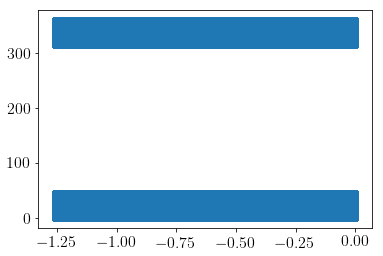

In [26]:
plt.scatter(nscdec, nscra)
plt.show()

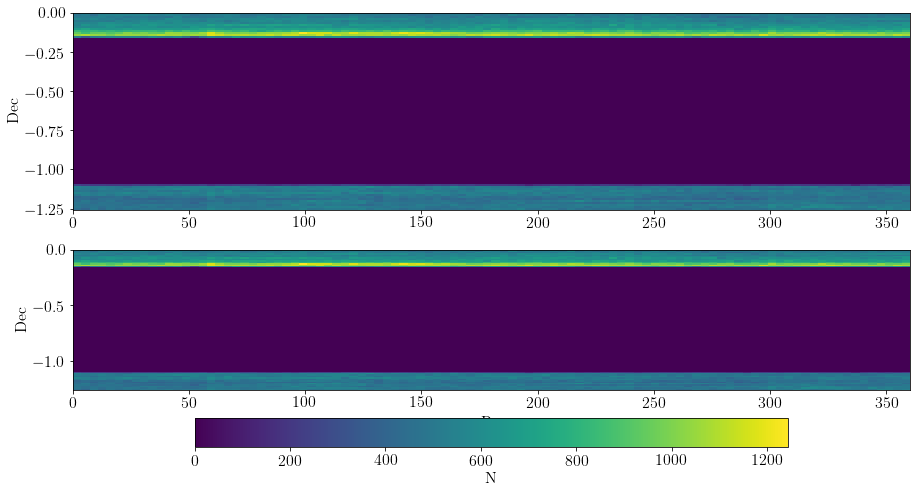

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
ax[0].imshow(N, origin='lower', aspect="auto", extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]])
#ax[0].set_ylim(-0.18, 0.02)

i = ax[1].imshow(N, origin='lower', aspect="auto", extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]])
#ax[1].set_ylim(-1.28, -1.09)

ax[0].set_ylabel("Dec")
ax[1].set_ylabel("Dec")
ax[1].set_xlabel("Ra")
plt.colorbar(mappable=i, ax=ax[1], pad=0.14, orientation='horizontal', label="N")
plt.show()